In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter


In [3]:
#Function to calculate mean squared error between two images
def mse(imageA, imageB):
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	return err

In [4]:
#Auxiliary Function to plot side by side
def plot_sidebyside(img_list,titles,colormap=None,figsize=(12,6)):
  n = len(img_list)
  figure, axis = plt.subplots(1, n, figsize=figsize)
  
  for i in range(n):  
    axis[i].imshow(img_list[i], cmap=colormap)
    axis[i].set_title(titles[i])
    axis[i].axis('off')
  # Combine all the operations and display
  plt.show()

In [5]:
#kernel for the dilation operation
k_cross = np.array([[0,1,0],
                  [1,1,1],
                  [0,1,0]], dtype=np.uint8)

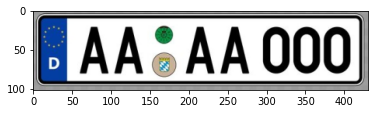

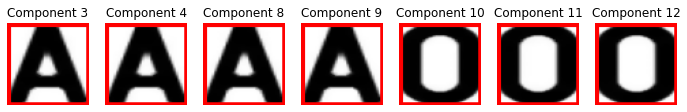

AAAA000


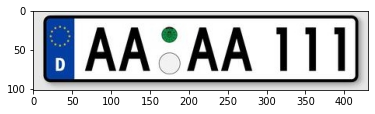

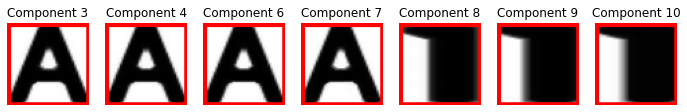

AAAA111


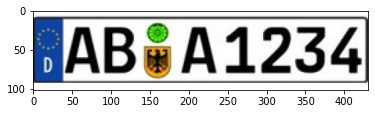

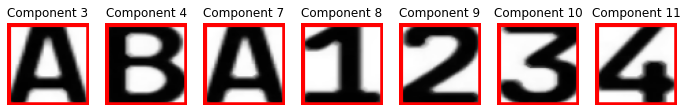

ABA1234


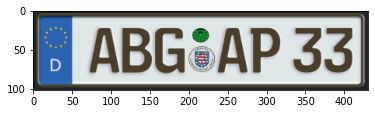

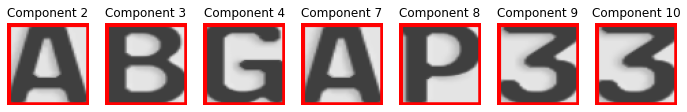

ABGAP33


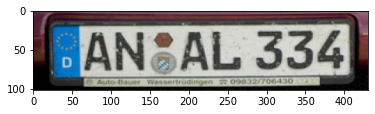

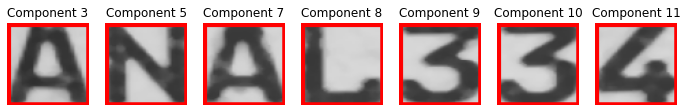

ANAL334


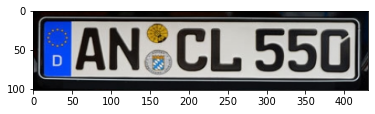

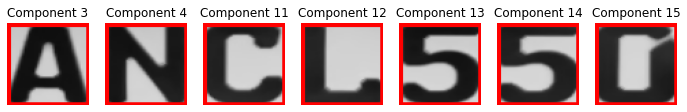

ANCL550


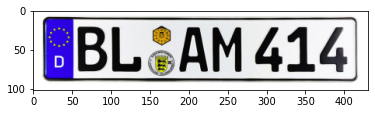

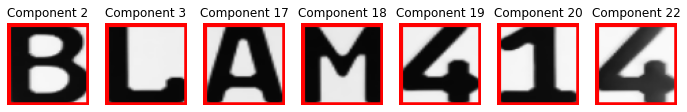

BLAM414


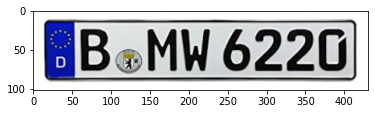

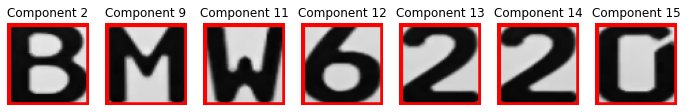

BMW6220



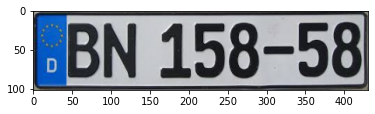

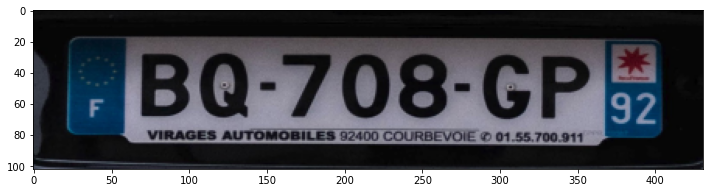

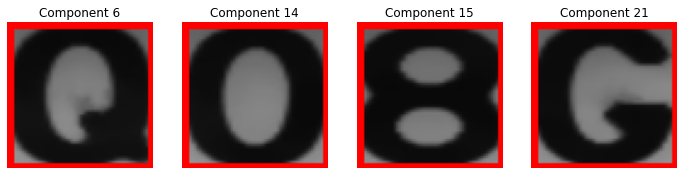

QO8G


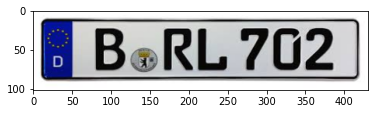

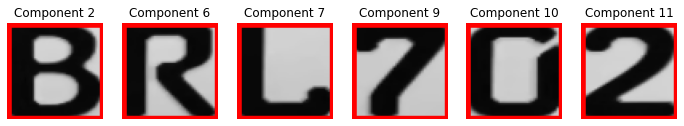

BRL702


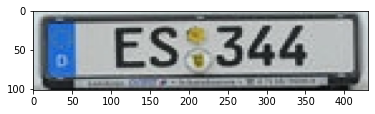

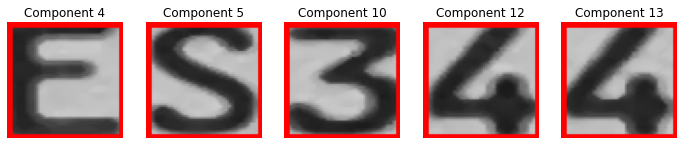

ES344


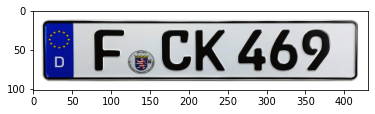

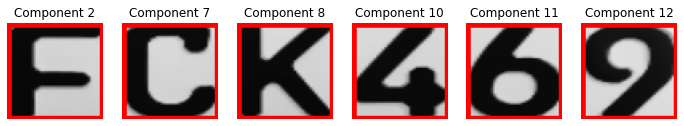

FCK469


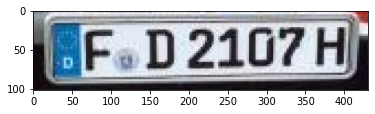

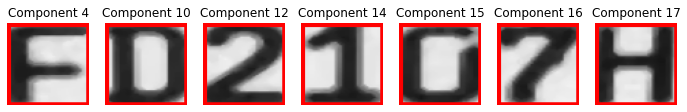

FD2107H


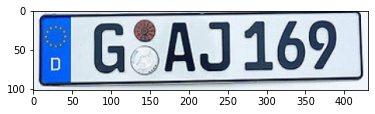

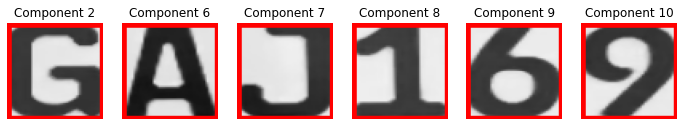

GAJ169


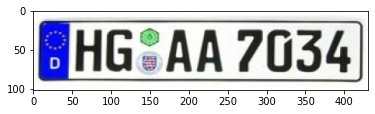

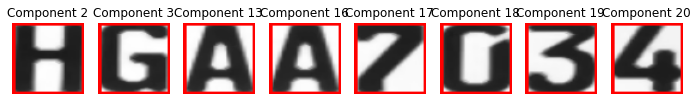

HGAA7034


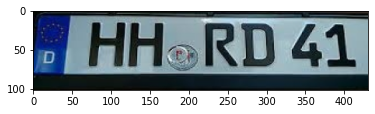

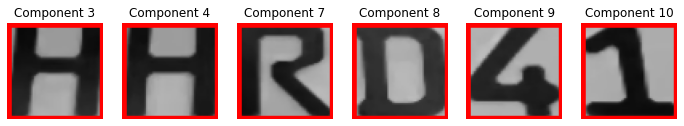

HHRD41


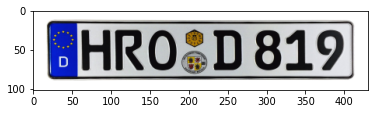

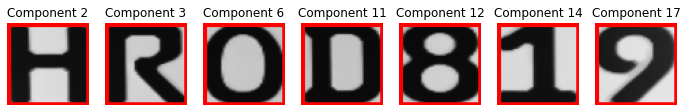

HROD819


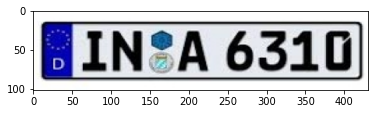

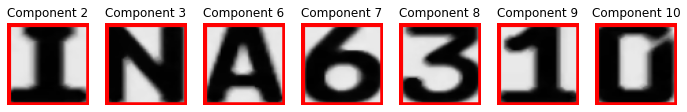

INA6310


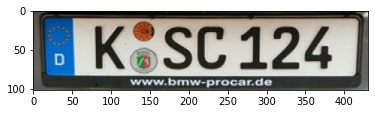

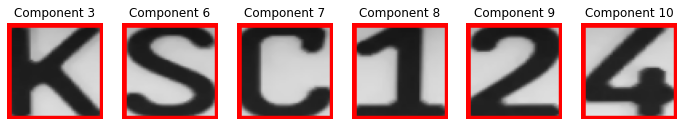

KSC124


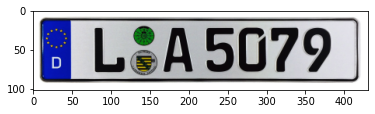

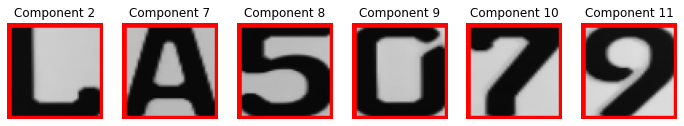

LA5079


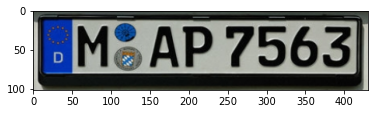

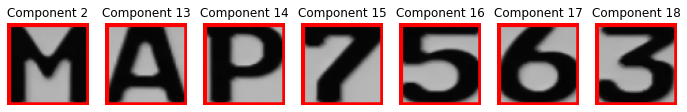

MAP7563


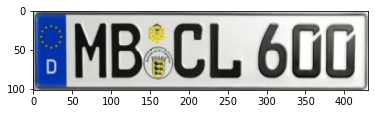

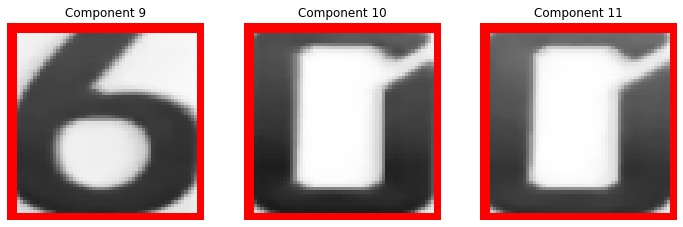

600


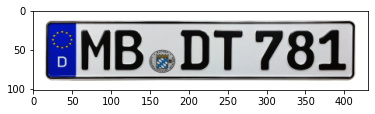

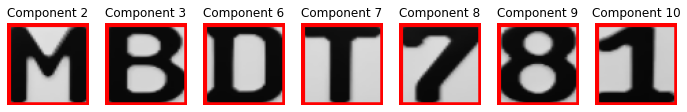

MBDT781


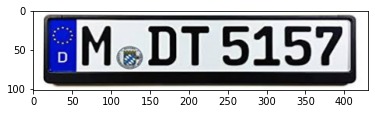

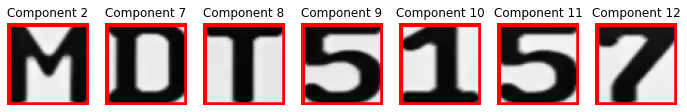

MDT5157


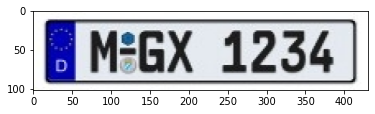

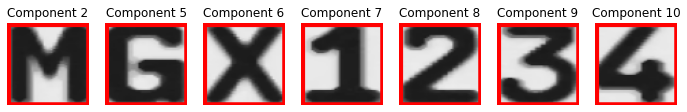

MGX1234



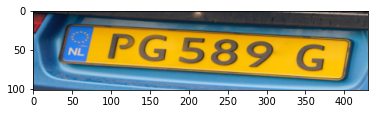

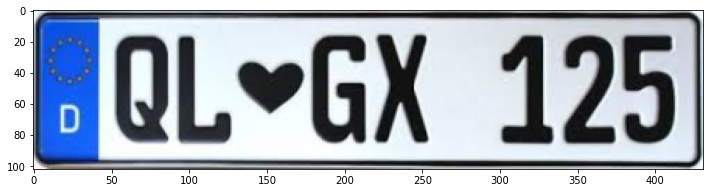

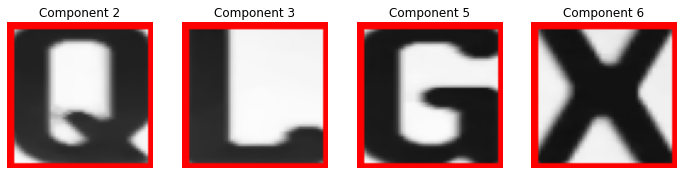

QLGX


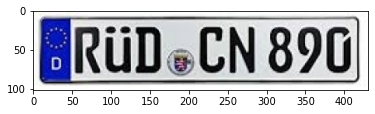

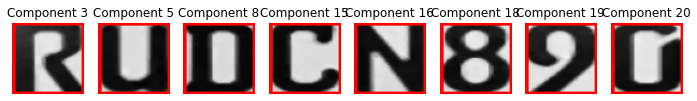

RUDCN890


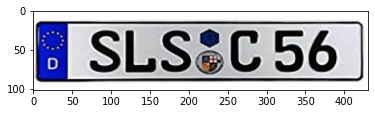

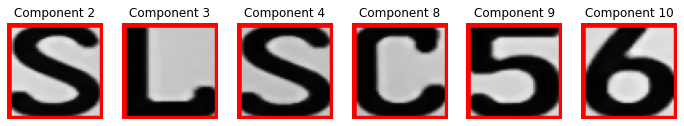

SLSC56


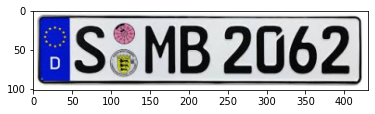

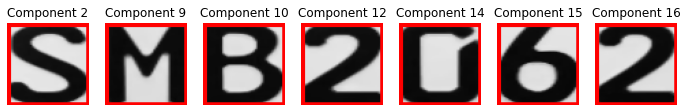

SMB2062


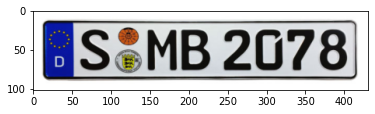

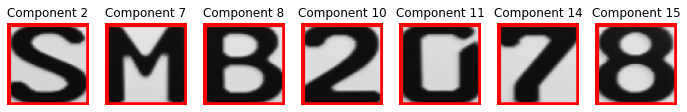

SMB2078


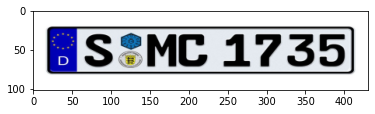

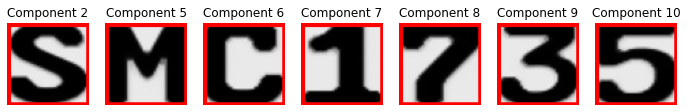

SMC1735


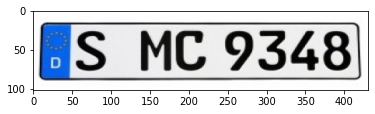

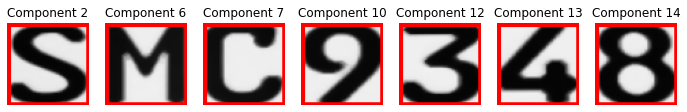

SMC9348


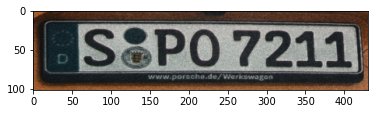

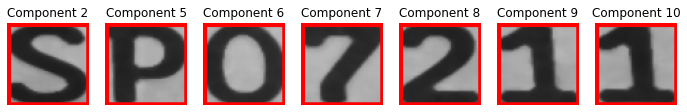

SPO7211


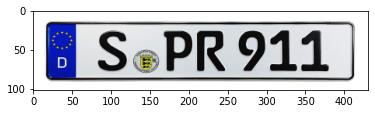

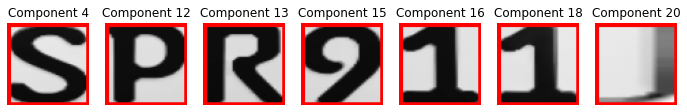

SPR911J



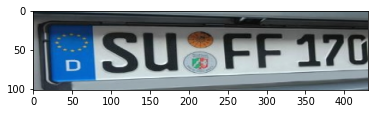

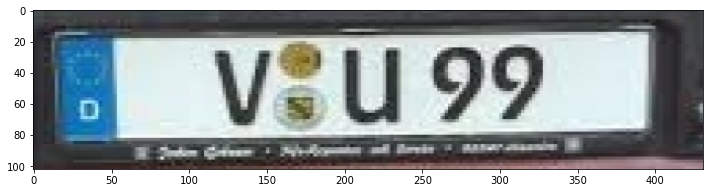

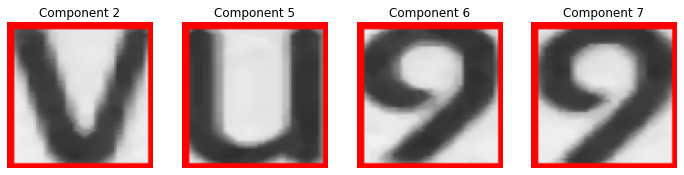

VU99


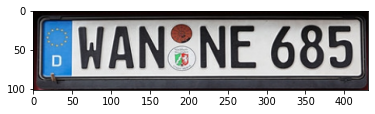

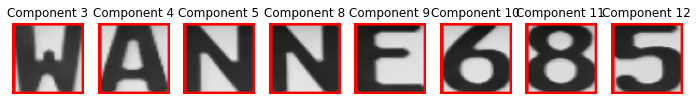

WANNE685


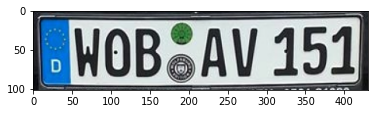

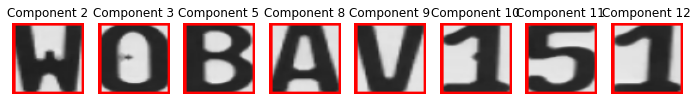

W0BAV151



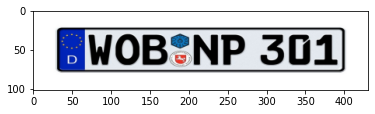

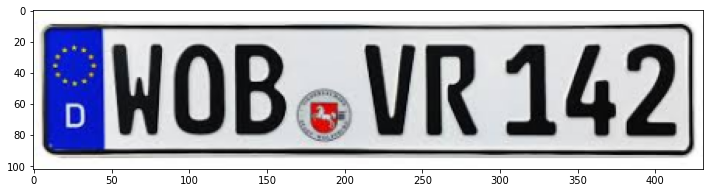

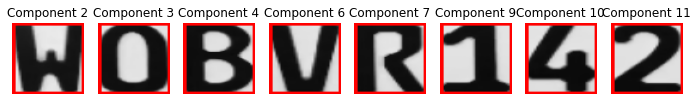

WOBVR142


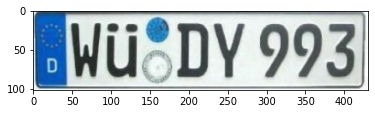

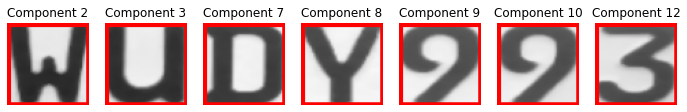

WUDY993


In [7]:
#lets load the license dataset and the labeled characters dataset
import glob
from turtle import width
image_plate_list = []
for filename in glob.glob('dataset/*.jpg'): 
    img_plate=cv2.imread(filename)
    image_plate_list.append(img_plate)

import glob
image_list = []
for filename in glob.glob('comparison/*.png'):
    im=cv2.imread(filename)
    image_list.append([im, filename[11]])
image_array = []

#for the labeled character dataset we will also append their label
for image in image_list:
    image_new = np.asarray(image[0])
    image_array.append([image_new, image[1]])



#for every license plate we are going to:
for img_plate in image_plate_list:
    #resize all the images so they are the same size
    img_plate = cv2.resize(img_plate, (431, 102), interpolation= cv2.INTER_AREA)
    #converts to rgb to better visualize
    img_plate = cv2.cvtColor(img_plate,cv2.COLOR_BGR2RGB)
    plt.imshow(img_plate)
    #plt.axis('off')
    #plt.show()
    #convert to grayscale
    gray = cv2.cvtColor(img_plate,cv2.COLOR_RGB2GRAY)
    #add blur
    gray = cv2.medianBlur(gray,5)
    #set the threshold
    _,thresh = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    #plot_sidebyside([gray,thresh],['Input','Thresh'],colormap='gray',figsize=(10,6))
    #set the connectivity to 4
    connectivity = 4
    #get the components
    num_labels, cc_image, stats, centroids = cv2.connectedComponentsWithStats(thresh , connectivity , cv2.CV_32S)
    #plot_sidebyside([gray,thresh,cc_image],['Input','Thresh','Connected Components'],colormap='gray')

    #print('Total Labels:', num_labels)
    #print(np.unique(cc_image))
    
    #we will now determine the components by a height and width limit
    comp_img = []
    comp_str = []
    
    for i in range(num_labels):
        temp = cc_image.copy()
        
        temp[cc_image == i] = 255
        temp[cc_image != i] = 0
        #sorting the elements from left to right
        stats = sorted(stats, key=itemgetter(0))
        x,y,w,h = (stats[i][:4])
        
        area = stats[i][4]
        cx,cy = centroids[i]

        
        if (h > 40 and h < 70) and (w < 50):
            component = gray[y:y + h, x:x+w]
            h,w = component.shape
            #getting the component and appending it to a list
            component = cv2.resize(component,(60,60))  
            component = cv2.cvtColor(component,cv2.COLOR_GRAY2BGR)      
            cv2.rectangle(component,(0,0),(60,60),(255,0,0),thickness=3)    
            comp_img.append(component)
            comp_str.append('Component ' + str(i))
    

    try:
        #try to plot the components and their labels
        plot_sidebyside(comp_img,comp_str,colormap='gray')
    except: 
        pass
    dist = []
    final_string = ''
    #for every component:
    for component in comp_img:
        #set the minimum MSE to a high number
        minim = 99999999
        #we set everything to the same size and dilate the components for better comparison
        component = cv2.cvtColor(component, cv2.COLOR_BGR2GRAY)
        component = cv2.resize(component, (60, 60), interpolation= cv2.INTER_AREA)
        component = cv2.dilate(component,k_cross)
        #for every image in the comparison folder
        for comparison in image_array:
            try:
                #we set to grayscale if needed
                comparison[0] = cv2.cvtColor(comparison[0], cv2.COLOR_BGR2GRAY)
                
            except:
                pass

            #resize the image
            comparison[0] = cv2.resize(comparison[0], (60, 60), interpolation= cv2.INTER_AREA)
            #we calculate the MSE
            mse_try = mse(component, cv2.dilate(comparison[0], k_cross))
            #if its lower than minim, we have a better match for that character so we save the character, the MSE, and the label
            if mse_try < minim:
                match = comparison[0]
                minim = mse_try
                string = comparison[1]
        #we join all characters to get the final string
        final_string += string
    #plt.imshow(img_plate)
    #plt.show()
    #we print the final string
    print(final_string.upper())

 
